In [1]:
from main import *
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
data = torch.load('x.pt')
model = data['model'].cuda()
assert(type(model) is ImageTextEncodeTransformModel)

In [ ]:
opt = parse_opt() 
opt.coco_path = '../datasets/coco'
opt.sic112_path = './SIC112/'
trainset, testset, sic112 = load_datasets(opt)

17919 745
sucessfully loaded features


In [4]:
# compute features for coco val 2014
def extract_features_from_dataset(model, testset, img_stop_num):
    model.eval()
    img_features = []
    text_features = []
    img_labels = []
    text_labels = []
    for data in testset.get_loader(batch_size = opt.batch_size, shuffle = False, drop_last= False):
        # extract image features
        imgs = np.stack([d['image'] for d in data])
        imgs = torch.from_numpy(imgs).float()
        if len(imgs.shape) == 2:
            imgs = model.img_encoder.fc(imgs.cuda())
        else:
            imgs = model.img_encoder(imgs.cuda())
        imgs = model.snorm(imgs).cpu().detach().numpy()
        img_features += [imgs]
        img_labels += [d['label'] for d in data]

        # text
        texts = []
        for d in data:
            texts += d['captions']
            text_labels += [d['label'] for c in d['captions']]
        texts = model.text_encoder(texts)
        texts = model.snorm(texts).cpu().detach().numpy()
        text_features += [texts]

        if len(img_labels) > img_stop_num:
            break

    img_features = np.concatenate(img_features, axis=0)
    text_features = np.concatenate(text_features, axis=0)
    return img_features, img_labels, text_features, text_labels

dataset = testset
img_features, _, _, _ = extract_features_from_dataset(model, dataset, len(dataset))

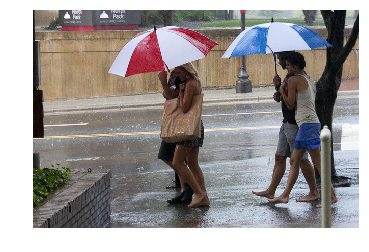

Query image 1454
Replace street with beach


In [5]:
# make a query
model.eval()
image_query_id = 1454
source_words = ['street']
target_words = ['beach']

img = dataset.get_raw_img(image_query_id)
plt.imshow(img)
plt.axis('off')
plt.show()
print 'Query image', image_query_id
print 'Replace', source_words[0], 'with', target_words[0]

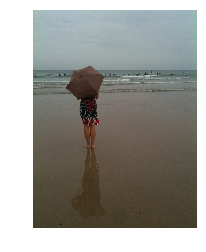

Ranked 1 similarity score 2.235445


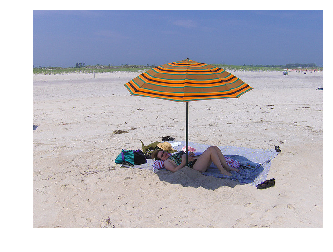

Ranked 2 similarity score 2.1674447


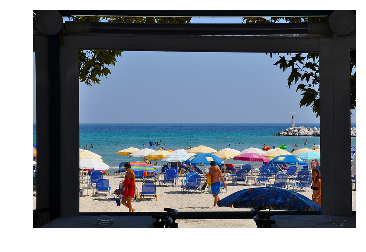

Ranked 3 similarity score 2.134197


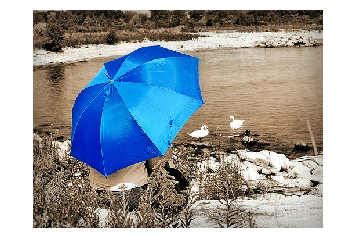

Ranked 4 similarity score 2.1264997


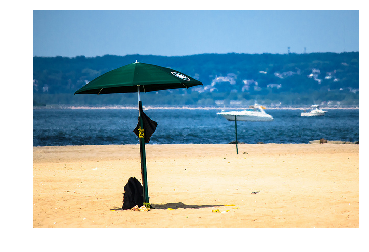

Ranked 5 similarity score 2.1087759
The End


In [6]:
# show retrieval result
source_words = model.text_encoder(source_words)
target_words = model.text_encoder(target_words)
source_img = img_features[image_query_id:(image_query_id+1),:]
source_img = torch.from_numpy(source_img).cuda()
source_img_to_target = model.transformer((source_img, source_words, target_words))
query = source_img_to_target.cpu().data.numpy()
sim = np.matmul(query, img_features.T)
ranked = np.argsort(sim)

for i in range(5):
    k = ranked[0,-i-1]
    img = dataset.get_raw_img(k)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    print 'Ranked', i+1, 'similarity score', sim[0, k]
    time.sleep(1)
print 'The End'